In [29]:
import mne
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from scipy import signal
from scipy.fft import fftshift
# from compute_abr import *
from bids import BIDSLayout

In [30]:
BIDS_ROOT = '../data/bids'
FS = 5000
stim_freqs = [130, 200, 280]

cond_dict = {
    (130, 1, 'l', True): ['211', '212', '213'],
    (200, 2, 'l', True): ['221', '222', '223'],
    (280, 3, 'l', True): ['231', '232', '233'],
    (130, 1, 'r', True): ['111', '121', '131'],
    (200, 2, 'r', True): ['112', '122', '132'],
    (280, 3, 'r', True): ['113', '123', '133'],
    (130, 1, 'l', False): ['111', '112', '113'],
    (200, 2, 'l', False): ['121', '122', '123'],
    (280, 3, 'l', False): ['131', '132', '133'],
    (130, 1, 'r', False): ['211', '221', '231'],
    (200, 2, 'r', False): ['212', '222', '232'],
    (280, 3, 'r', False): ['213', '223', '233']
}

right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']
left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']


In [12]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocess_ffr')
all_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'forFFR')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
    
        # Compute dB for each channel
        cond_epochs = epochs[event_ids]
        dB, freq = get_dB(cond_epochs) # dB should be n_chans * n_freq

        # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
        df = pd.DataFrame(
            {'sub': sub,
             'freq': freq,
             'stim': stim,
             'stream': condition[2],
             'attended': condition[3],
             'dB': dB
            }
        )
        all_spectrums.append(df)
#         break
#     break

spectrums = pd.concat(all_spectrums)
spectrums.to_csv('spectrums.csv', sep = '\t', index = False)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-9/sub-9_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
936 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
936 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-24/sub-24_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1572 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1572 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-35/sub-35_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
597 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
597 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-6/sub-6_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
2245 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2245 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-42/sub-42_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1158 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1158 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-33/sub-33_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1841 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-41/sub-41_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1830 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-11/sub-11_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
346 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-14/sub-14_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-38/sub-38_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-8/sub-8_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1748 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1748 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-5/sub-5_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1222 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-39/sub-39_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
635 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
635 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-43/sub-43_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1625 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1625 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-31/sub-31_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1345 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1345 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-4/sub-4_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
401 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
401 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-25/sub-25_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_32402/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_32402/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_ch

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_32402/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_32402/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your deriva

Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-29/sub-29_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1640 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1640 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-40/sub-40_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1798 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1798 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

## Plot

In [13]:
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
spectrums

,sub,freq,stim,stream,attended,dB
0,9,102.329451,130,l,True,-1.209650
1,9,104.825291,130,l,True,-1.071550
2,9,107.321131,130,l,True,0.643601
3,9,109.816972,130,l,True,1.043218
4,9,112.312812,130,l,True,0.689737
...,...,...,...,...,...,...
18235,40,289.517471,280,r,False,3.224310
18236,40,292.013311,280,r,False,-0.306604
18237,40,294.509151,280,r,False,0.441660
18238,40,297.004992,280,r,False,-1.406790


(100.0, 300.0)

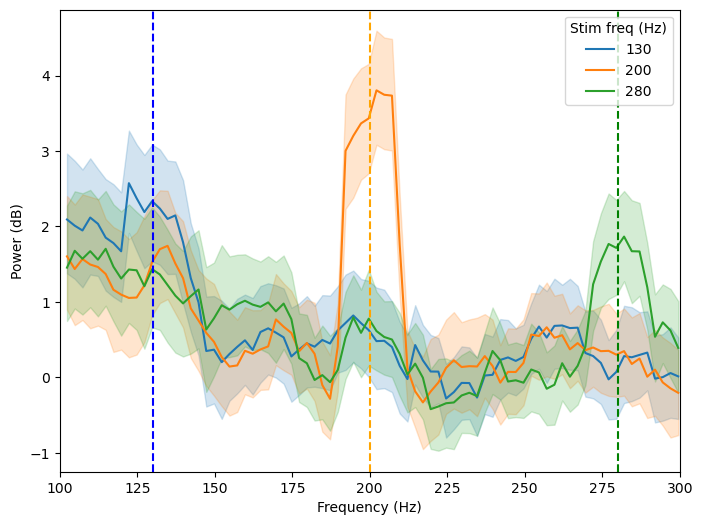

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = spectrums, x = "freq", y = "dB", hue = "stim", palette = 'tab10', ax = ax)
graph.axvline(130, linestyle = 'dashed', color = 'blue')
graph.axvline(200, linestyle = 'dashed', color = 'orange')
graph.axvline(280, linestyle = 'dashed', color = 'green')
graph.legend(title = 'Stim freq (Hz)')
graph.set_ylabel("Power (dB)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(100, 300)

### Basic ANOVA

In [15]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocess_ffr')
stim_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'forFFR')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
    
        # Compute dB for each channel
        cond_epochs = epochs[event_ids]
        dB, freqs = get_dB(cond_epochs) # dB should be n_chans * n_freq

        # Iterate over stim freqs
        for freq in stim_freqs:
        
            # select Fourier frequencies around stimulus frequency
            idx = np.abs(freqs - freq).argmin()
            freq_dB = dB[idx]
    
            # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
            df = pd.DataFrame(
                {'sub': sub,
                 'freq': freq,
                 'stim': stim,
                 'stream': condition[2],
                 'attended': condition[3],
                 'dB': [freq_dB]
                }
            )
        stim_spectrums.append(df)

stim_spectrums = pd.concat(stim_spectrums)
stim_spectrums = stim_spectrums.reset_index(drop = True)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-9/sub-9_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
936 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
936 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-24/sub-24_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1572 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1572 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-35/sub-35_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
597 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
597 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-6/sub-6_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
2245 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2245 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-42/sub-42_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1158 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1158 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-33/sub-33_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1841 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1841 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-41/sub-41_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1830 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1830 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-11/sub-11_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
346 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
346 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-14/sub-14_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1710 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-38/sub-38_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
154 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-8/sub-8_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1748 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1748 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-5/sub-5_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1222 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1222 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-39/sub-39_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
635 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
635 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spec

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-43/sub-43_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1625 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1625 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-31/sub-31_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1345 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1345 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-4/sub-4_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
401 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
401 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-25/sub-25_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectr

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_32402/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_32402/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/letitiayhho/.conda/envs/pitch-tracking/lib/py

    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_32402/1215958834.py:20: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P = epochs.average().compute_psd(tmin = 0, tmax = 0.4, fmin = 100, fmax = 300)
/tmp/ipykernel_32402/1215958834.py:21: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  P0 = epochs.average().compute_psd(tmin = -0.4, tmax = 0, fmin = 100, fmax = 300)
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-29/sub-29_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1640 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1640 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocess_ffr/sub-40/sub-40_task-dichotic_run-1_desc-forFFR_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     400.00 ms
        0 CTF compensation matrices available
Not setting metadata
1798 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1798 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper sp

In [16]:
spectrums

,sub,freq,stim,stream,attended,dB
0,9,102.329451,130,l,True,-1.209650
1,9,104.825291,130,l,True,-1.071550
2,9,107.321131,130,l,True,0.643601
3,9,109.816972,130,l,True,1.043218
4,9,112.312812,130,l,True,0.689737
...,...,...,...,...,...,...
18235,40,289.517471,280,r,False,3.224310
18236,40,292.013311,280,r,False,-0.306604
18237,40,294.509151,280,r,False,0.441660
18238,40,297.004992,280,r,False,-1.406790


In [18]:
aov = AnovaRM(
    data = stim_spectrums, 
    depvar = 'power',
    subject = 'sub', 
    within = ['freq', 'stim', 'stream']
)
res = aov.fit()
print(res)

ValueError: The data set contains more than one observation per subject and cell. Either aggregate the data manually, or pass the `aggregate_func` parameter.

In [19]:
drop_attended = stim_spectrums.groupby(['sub', 'freq', 'stim', 'stream'], as_index = False)['dB'].mean()
aov = AnovaRM(
    data = drop_attended, 
    depvar = 'dB',
    subject = 'sub', 
    within = ['freq', 'stim', 'stream']
)
res = aov.fit()
print(res)

                    Anova
                 F Value Num DF  Den DF Pr > F
----------------------------------------------
freq                 nan 0.0000  0.0000    nan
stim              7.3764 2.0000 36.0000 0.0021
stream            1.5562 1.0000 18.0000 0.2282
freq:stim            nan 0.0000  0.0000    nan
freq:stream          nan 0.0000  0.0000    nan
stim:stream       0.1441 2.0000 36.0000 0.8663
freq:stim:stream     nan 0.0000  0.0000    nan



/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:601: RuntimeWarning: invalid value encountered in double_scalars
  mse = (ssr1 - ssr) / df2
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:601: RuntimeWarning: invalid value encountered in double_scalars
  mse = (ssr1 - ssr) / df2
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/statsmodels/stats/anova.py:591: RuntimeWarning: invalid value encountered in double_scalars
  msm = (ssr1 - ssr) / df1
/home/letitiayhho/.conda/envs/pitch

### Compute spectrum by hemisphere

In [32]:
def get_hemisphere_channels(ch_names):
    left_channels = ['AF3', 'C1','C3','C5','T7','CP1','CP3','CP5','F1','F3','F5','F7','FC1','FC3','FC5','FT7','FT9','Fp1','O1','P1','P3','P5','P7','PO3','PO7','TP7','TP9']
    right_channels = ['AF4','C2','C4','C6','T8','CP2','CP4','CP6','F2','F4','F6','F8','FC2','FC4','FC6','FT10','FT8','Fp2','O2','P2','P4','P6','P8','PO4','PO8','TP10','TP8']

    # Find channels that are missing
    missing = set(left_channels + right_channels) - set(ch_names)
    print(f'----------missing chans: {missing}')

    # Pop from both hemispheres
    for channel in missing:
        if channel in left_channels:
            i = left_channels.index(channel)
        elif channel in right_channels:
            i = right_channels.index(channel)
        right_channels.pop(i)
        left_channels.pop(i)
        
    return left_channels, right_channels, missing

In [33]:
coords = pd.read_csv('../data/captrak/2dcoords.csv')
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subs = layout.get_subjects(scope = 'preprocessing')
diff_spectrums = []

for sub in subs:
    # Load data
    epochs = read_epochs(sub, 'clean')
    
    # Iterate over conditions
    for condition, event_ids in cond_dict.items():
        stim = condition[0]
        
        # Pick channels for each hemisphere
        left_channels, right_channels, missing = get_hemisphere_channels(epochs.ch_names)
        left_epochs = epochs[event_ids].pick(left_channels)
        right_epochs = epochs[event_ids].pick(right_channels)

        # Compute dB for each channel
        left_dB, psd_freqs = get_dB(left_epochs) # dB should be n_chans * n_freq
        right_dB, psd_freqs = get_dB(right_epochs) # preserves the requested channel order given as its picks parameter
        dB_diff = left_dB - right_dB
        
        # Iterate over stim freqs
        for freq in stim_freqs:
        
            # select Fourier frequencies around stimulus frequency
            idx = np.abs(psd_freqs - freq).argmin()
            freq_dB_diff = dB_diff[:,idx]

            # Get channel coordinates
            x, y = get_channel_coords(coords, left_channels)

            # Create data frame (channel name, hemisphere, stim_freq, stream, attended, dB)
            df = pd.DataFrame(
                {'sub': sub,
                 'left_chs': left_channels,
                 'x': x,
                 'y': y,
                 'freq': freq,
                 'stim': stim,
                 'stream': condition[2],
                 'attended': condition[3],
                 'dB_diff': freq_dB_diff
                }
            )
            
            # Add nan row for every missing channel
            for chan in missing:
                df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
            
            # Check
            if np.shape(df) != (27, 9):
                raise ValueError('df is not the right shape, some channels may be missing')
            
            diff_spectrums.append(df)
#             break
#         break
#     break

diff_spectrums = pd.concat(diff_spectrums)
diff_spectrums.to_csv('diff_spectrums.csv', sep = '\t', index = False)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-9/sub-9_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1558 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1558 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-24/sub-24_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1450 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1450 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-35/sub-35_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...


/tmp/ipykernel_32402/1215958834.py:14: RuntimeWarning: This filename (/project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-35/sub-35_task-dichotic_run-1_desc-clean_epo.fif-1.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_all = [mne.read_epochs(f) for f in fnames]


    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-35/sub-35_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-35/sub-35_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
2175 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
3262 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-6/sub-6_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1858 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1858 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-42/sub-42_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1253 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1253 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-33/sub-33_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1846 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1846 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-41/sub-41_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1636 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1636 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-11/sub-11_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1765 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1765 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-14/sub-14_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1725 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1725 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...


/tmp/ipykernel_32402/1215958834.py:14: RuntimeWarning: This filename (/project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_all = [mne.read_epochs(f) for f in fnames]


    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1151 matching events found
No baseline correction applied
0 projection items activated
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-38/sub-38_task-dichotic_run-1_desc-clean_epo.fif-1.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
2303 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
3454 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-8/sub-8_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1498 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1498 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-5/sub-5_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1685 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1685 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-39/sub-39_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1836 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1836 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-43/sub-43_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1782 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1782 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-31/sub-31_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1412 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1412 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-4/sub-4_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1465 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1465 matching events found
Applying baseline correction (mode: mean)
----------missing chans: {'T8'}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: {'T8'}


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[-1] = [sub, chan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
/tmp/ipykernel_32402/1633218732.py:50: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bool

Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-25/sub-25_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
162 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOT

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-30/sub-30_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1791 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1791 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-29/sub-29_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1479 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1479 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Reading /project2/hcn1/dichotic_pitch_tracking/analysis/../data/bids/derivatives/preprocessing/sub-40/sub-40_task-dichotic_run-1_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -400.00 ...     450.00 ms
        0 CTF compensation matrices available
Not setting metadata
1771 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_32402/1215958834.py:15: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs_all)


Not setting metadata
1771 matching events found
Applying baseline correction (mode: mean)
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
----------missing chans: set()
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NO